## Python model that trains and evaluates a deep learning classifier on the MNIST dataset. 


## Load and Preprocess Data
I start by loading the MNIST dataset, which contains images of handwritten digits. The images are then preprocessed to ensure they're in the right format for training.

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split

In [49]:
import keras
keras.__version__

'2.15.0'

## Training using the MNIST dataset
The following network will be used to process the MNIST dataset
The following code will load the MNIST dataset from keras. 

In [52]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255.0
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255.0

# Use a smaller subset of the data for tuning and training in case the original is large
#subset_size = 1000
#train_images_subset, _, train_labels_subset, _ = train_test_split(train_images, train_labels, test_size=(1 - subset_size/len(train_images)))

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1)


In [53]:
train_images.shape

(54000, 28, 28, 1)

In [54]:
test_images.shape

(10000, 28, 28, 1)

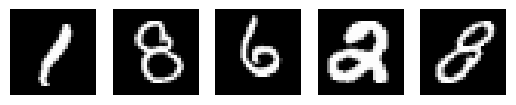

In [56]:
%matplotlib inline
from matplotlib import pyplot as plt
for i in range(5):
    plt.subplot(1,5,1+i)
    plt.axis('off')
    plt.imshow(train_images[i], cmap="gray")

## Define Hyperparameter Search Space and Initialize Tuner
I set up the architecture of our neural network and create a tuner to search for the best hyperparameters.
\
I have used the model (build_deep_nn) which defines a deep neural network architecture using Keras. 
the number of hidden layer will range from min 1 to max 3, the tuner will esplore the different combination and will choose the best combition that will give the best validation accuracy
\
The hidden size ranges from:
 'min_value': 32, 'max_value': 128, 'step': 32
 
the output of optimal hyperparameters are in the next step!!


In [43]:
# Define the hyperparameter search space
# Build the model with the optimal hyperparameters
# Modified Model
from tensorflow import keras
from tensorflow.keras import layers

def build_deep_nn(rows, columns, channels, num_hidden, hidden_sizes, dropout_rates, output_size, output_activation):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(rows, columns, channels)))

    for i in range(num_hidden):
        model.add(layers.Dense(hidden_sizes[i], activation='relu'))
        if dropout_rates[i] > 0:
            model.add(layers.Dropout(dropout_rates[i]))

    model.add(layers.Dense(output_size, activation=output_activation))
    
    return model

model = build_deep_nn(28, 28, 1, 2, (40, 20), (0, 0.5), 10, 'sigmoid')
model.summary()

print(model.layers[1].get_config()['activation'])  # Output: 'relu'
print(model.layers[2].get_config()['activation'])  # Output: 'relu'
print(model.layers[4].get_config()['activation'])  # Output: 'sigmoid'

# Initialize tuner
tuner = RandomSearch(
    build_deep_nn,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='mnist_tuning'
)
tuner.search_space_summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 40)                31400     
                                                                 
 dense_22 (Dense)            (None, 20)                820       
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_23 (Dense)            (None, 10)                210       
                                                                 
Total params: 32430 (126.68 KB)
Trainable params: 32430 (126.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
relu
relu
sigmoi

In [44]:
print(train_images.shape, train_labels.shape, val_images.shape, val_labels.shape)


(54000, 28, 28, 1) (54000,) (6000, 28, 28, 1) (6000,)


## Search for the Best Hyperparameters
I searched for the best hyperparameters using a subset of the training data.

In [45]:
# Search for the best hyperparameters
tuner.search(train_images, train_labels, epochs=5, validation_data=(val_images, val_labels))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal hyperparameters
print("Optimal Hyperparameters:")
print(f"Number of hidden layers: {best_hps.get('num_hidden_layers')}")
print(f"Hidden layer size: {best_hps.get('hidden_size')}")
dropout_rates = [0.5 if i == best_hps.get('num_hidden_layers') - 1 else 0 for i in range(best_hps.get('num_hidden_layers'))]
print(f"Dropout rates: {dropout_rates}")

Optimal Hyperparameters:
Number of hidden layers: 3
Hidden layer size: 128
Dropout rates: [0, 0, 0.5]


## Compile and Train the Model with Optimal Hyperparameters
I used the best hyperparameters to build and train the neural network.

In [46]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using the full training set
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.8134 - accuracy: 0.7314 - val_loss: 0.2601 - val_accuracy: 0.9263
Epoch 2/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4958 - accuracy: 0.8469 - val_loss: 0.2064 - val_accuracy: 0.9402
Epoch 3/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4185 - accuracy: 0.8711 - val_loss: 0.1896 - val_accuracy: 0.9447
Epoch 4/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3726 - accuracy: 0.8816 - val_loss: 0.1758 - val_accuracy: 0.9508
Epoch 5/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3457 - accuracy: 0.8899 - val_loss: 0.1662 - val_accuracy: 0.9533
Epoch 6/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3276 - accuracy: 0.8958 - val_loss: 0.1618 - val_accuracy: 0.9595
Epoch 7/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3162 - accuracy: 0.8961 - val_loss: 0.1576 - val_accuracy:

## Evaluate the Model on the Test Set
Finally, we evaluate the trained model on the test set to see how well it performs.

In [47]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1579 - accuracy: 0.9602
Test accuracy: 0.9602000117301941


### Hyperparameters of the optimal model:

* Optimal Hyperparameters:
* Number of hidden layers: 3
* Hidden layer size: 128
* Dropout rates: [0, 0, 0.5]

### The accuracy results of the optimal model on the test set:

**Test accuracy: 0.9602**